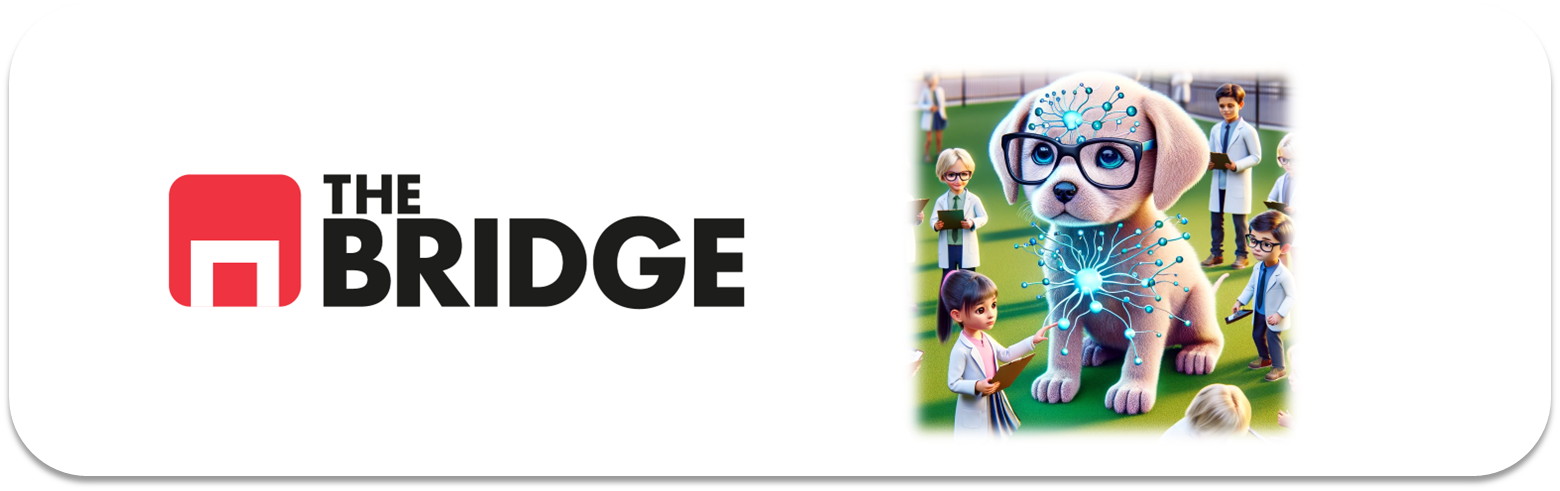

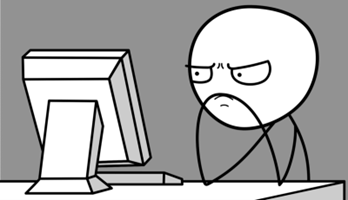

Para ejercitarte y afianzar lo aprendido sobre **Redes Recurrentes y series temporales**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import ARIMA, auto_arima
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from packaging import version
assert version.parse(tf.__version__) >= version.parse("2.8.0")

### Problema a resolver

El ayuntamiento de New City está preocupado por el nivel de contaminación de aire y quiere poner en marcha un sistema de prevención del uso de determinado tipo de vehículos y maquinaria pesada en aquellos días en los que la contaminación sea muy alta, en concreto queremos anticiparnos en periodos de 6 horas. Como primer paso para la implantación de la medida, decide crear un modelo de predicción de contaminación de forma que pueda emplearlo para enviar alertas o avisos de posible de prohibición con la suficiente anticipación que permita a los ciudadanos y trabajadores organizarse mejor. 

Para ello nos ha suministrado una serie de datos de contaminación del aire en cinco años dependiente de una serie de features que son medibles día a día y nos pide crear dicho modelo. Como somos unos "pioneros" vamos a hacerlo empleando lo aprendido con redes recurrentes.

A través de los siguientes ejercicios vamos a crear un modelo de regresión que permita estimar dicha polución en los periodos estimados. Aquí tienes un breve descripción de las columnas:

- **No**: número de fila
- **year**: año de los datos en esta fila
- **month**: mes de los datos en esta fila
- **day**: día de los datos en esta fila
- **hour**: hora de los datos en esta fila
- **pm2.5**: concentración de PM2.5
- **DEWP**: Punto de rocío
- **TEMP**: Temperatura
- **PRES**: Presión
- **cbwd**: Dirección combinada del viento
- **Iws**: Velocidad acumulada del viento
- **Is**: Horas acumuladas de nieve
- **Ir**: Horas acumuladas de lluvia


### Ejercicio 1: Visión preliminar

Carga el dataset. Echa un vistazo (no pintes series todavía) y decide cuál debe ser el target.

In [2]:
df = pd.read_csv("data/air_pollution_new_city.csv", sep = "|")
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43800 non-null  int64  
 1   year    43800 non-null  int64  
 2   month   43800 non-null  int64  
 3   day     43800 non-null  int64  
 4   hour    43800 non-null  int64  
 5   pm2.5   43800 non-null  float64
 6   DEWP    43800 non-null  int64  
 7   TEMP    43800 non-null  float64
 8   PRES    43800 non-null  float64
 9   cbwd    43800 non-null  object 
 10  Iws     43800 non-null  float64
 11  Is      43800 non-null  int64  
 12  Ir      43800 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


- No hay nulos, y el target sería pm2,5 que entiendo que es la polución acumuluda.

### Ejercicio 2: Preparación del dataset

Como todo dataset con series temporales, si tenemos las fechas, es conveniente convertirla a datatime y luego hacerlo el indice de nuestro dataset. Hazlo sobre un dataframe df_indexed copia del original. Deshazte de las columnas que no sean informativas y cambia el nombre de las columnas para que sean más "expresivas".

In [4]:
df_indexed = df.copy()
df_indexed["fecha"] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df_indexed.drop(columns=['year', 'month', 'day', 'hour','No'], inplace=True)
df

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,25,2019,1,2,0,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,26,2019,1,2,1,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,27,2019,1,2,2,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,28,2019,1,2,3,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,29,2019,1,2,4,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43795,43820,2023,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43796,43821,2023,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43797,43822,2023,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43798,43823,2023,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [5]:
df_indexed = df_indexed.sort_values("fecha").set_index("fecha")
df_indexed

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
fecha,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2023-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2023-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [6]:
df_indexed= df_indexed.rename(columns={
    'pm2.5': 'polucion',
    'DEWP': 'punto_rocio',
    'TEMP': 'temp',
    'PRES': 'pres',
    'cbwd': 'direccion_viento',
    'Iws': 'velocidad_viento',
    'Is': 'horas_nieve_acumulada',
    'Ir': 'horas_lluvia_acumuluda'
})
df_indexed.head()

,polucion,punto_rocio,temp,pres,direccion_viento,velocidad_viento,horas_nieve_acumulada,horas_lluvia_acumuluda
fecha,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


### Ejercicio 3: Split y MiniEda_I

Antes de continuar es hora analizar visualmente las series, pero para hacerlo formalmente correcto, analiza sólo de 2019 a 2022 (2023 será nuestro periodo de validaciones y test). Crea una gráfica com el target para el periodo de train. Descompón la serie de forma aditiva y analiza visualmente si existe estacionalidad, tendencia y si podríamos decir si es estacionaria o no

In [8]:
train_set = df_indexed.loc[:"2022"]
train_set

,polucion,punto_rocio,temp,pres,direccion_viento,velocidad_viento,horas_nieve_acumulada,horas_lluvia_acumuluda
fecha,,,,,,,,
2019-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2019-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2019-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2019-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2019-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0
...,...,...,...,...,...,...,...,...
2022-12-31 19:00:00,22.0,-19,7.0,1013.0,NW,114.87,0,0
2022-12-31 20:00:00,18.0,-21,7.0,1014.0,NW,119.79,0,0
2022-12-31 21:00:00,23.0,-21,7.0,1014.0,NW,125.60,0,0


In [13]:
target = "polucion"

In [10]:
test_set = df_indexed.loc["2023":]

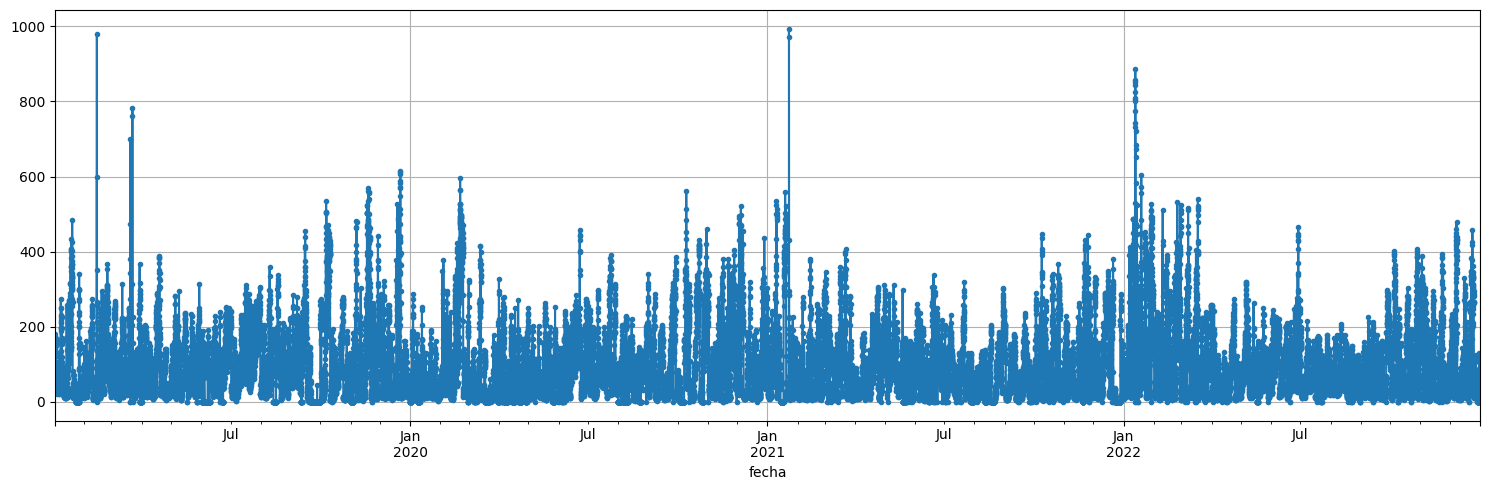

In [19]:
train_set[target].plot(grid = True, marker = ".", figsize = (15,5) ) 
plt.tight_layout()

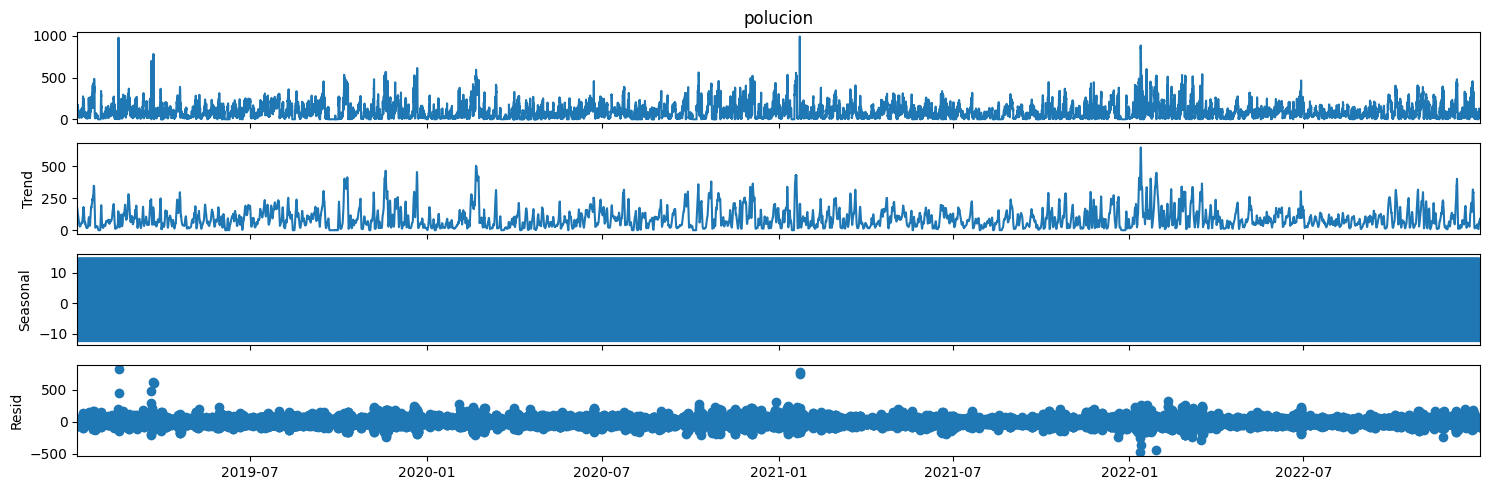

In [24]:

result_add = seasonal_decompose(train_set[target], model = 'additive', extrapolate_trend = 'freq')


plt.rcParams.update({'figure.figsize': (15,5)})
result_add.plot();

### Ejercicio 4: MiniEDA (II)

Para completar el minieda, crea una figura con tantos subplots como series temporales y en cada subplot muestra una de las series para el train. Empieza por el target y haz un pequeño análisis visual. Por supuesto, emplea sólo el train

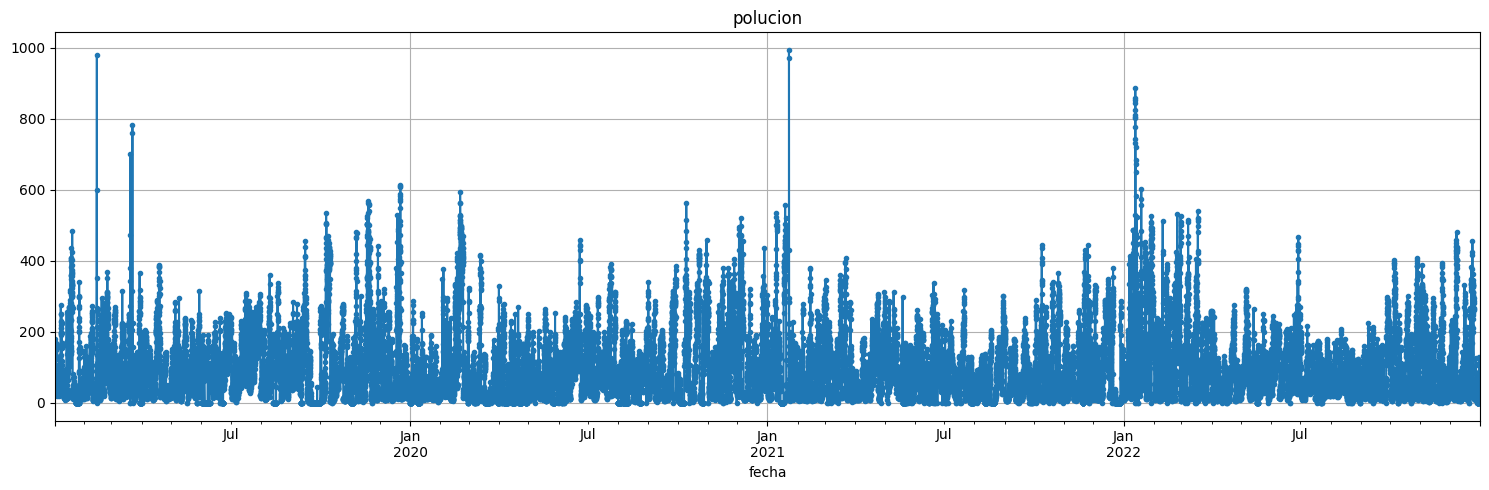

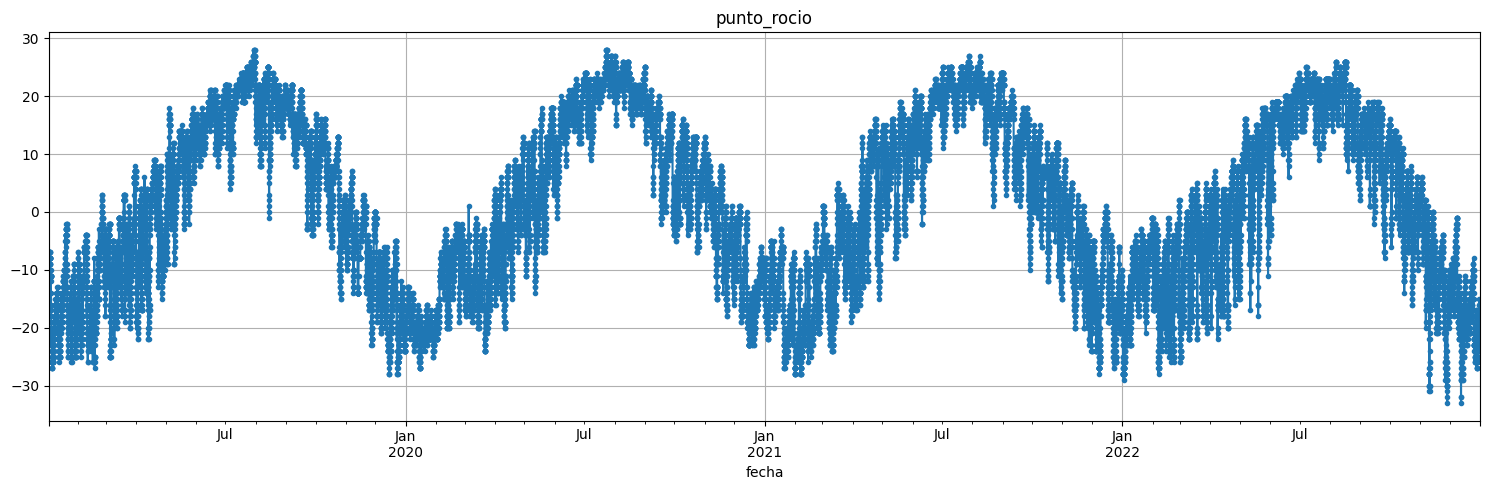

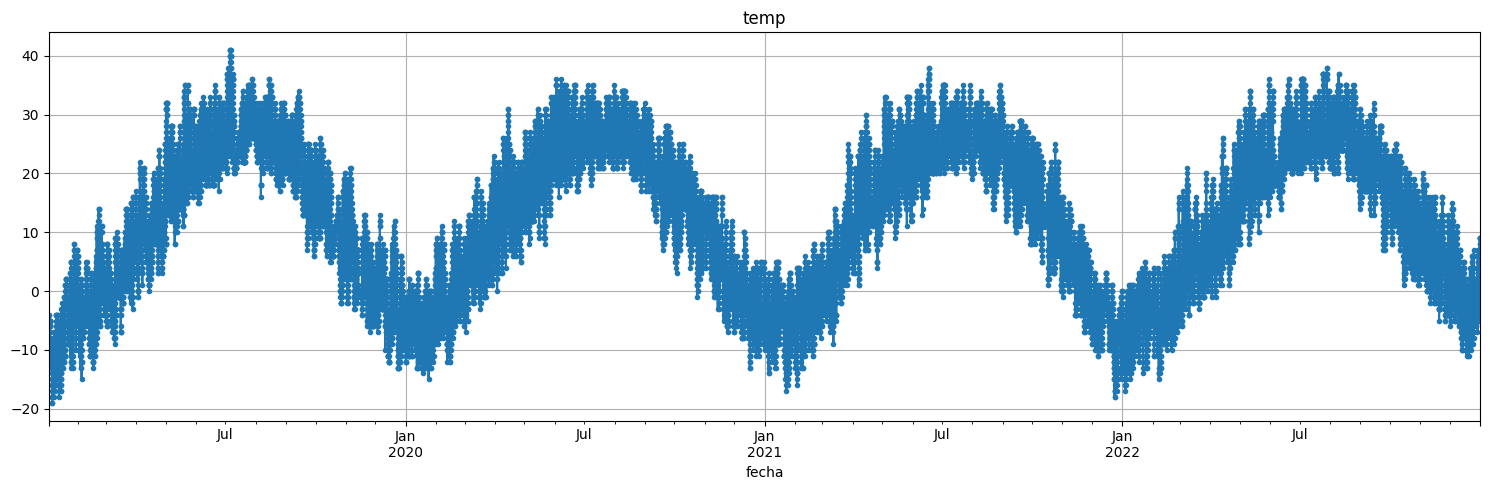

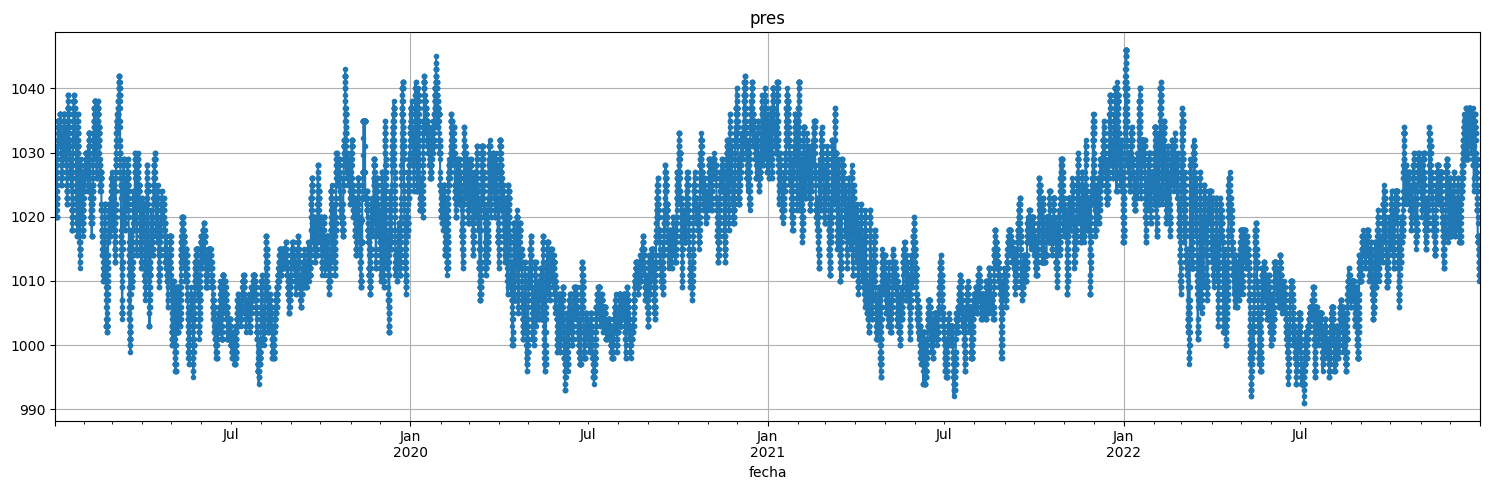

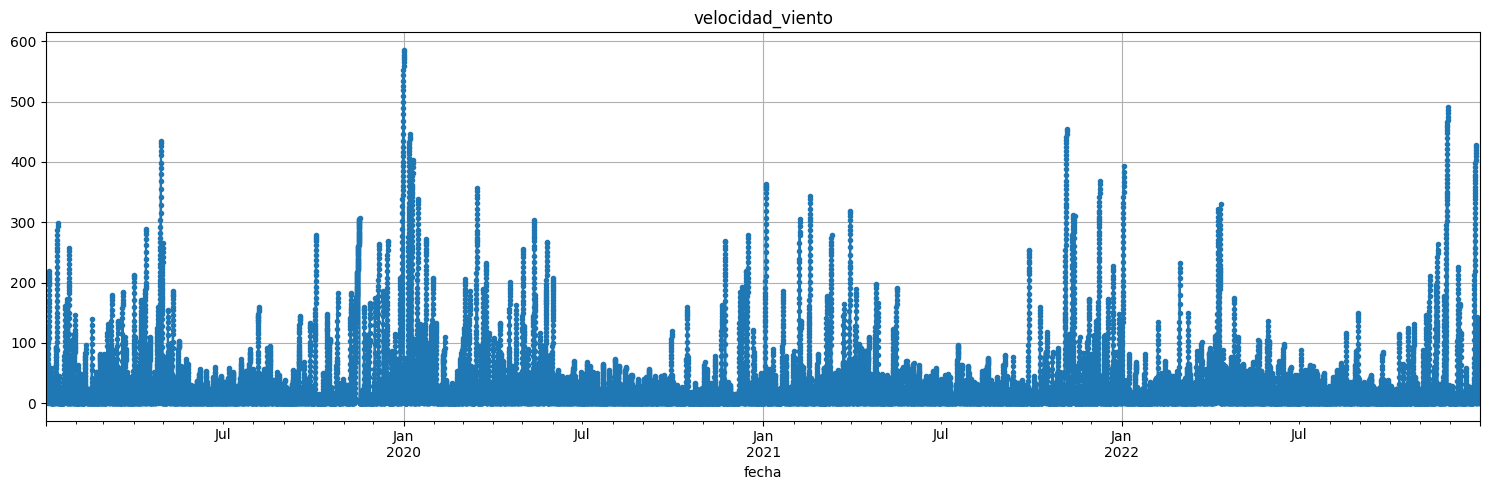

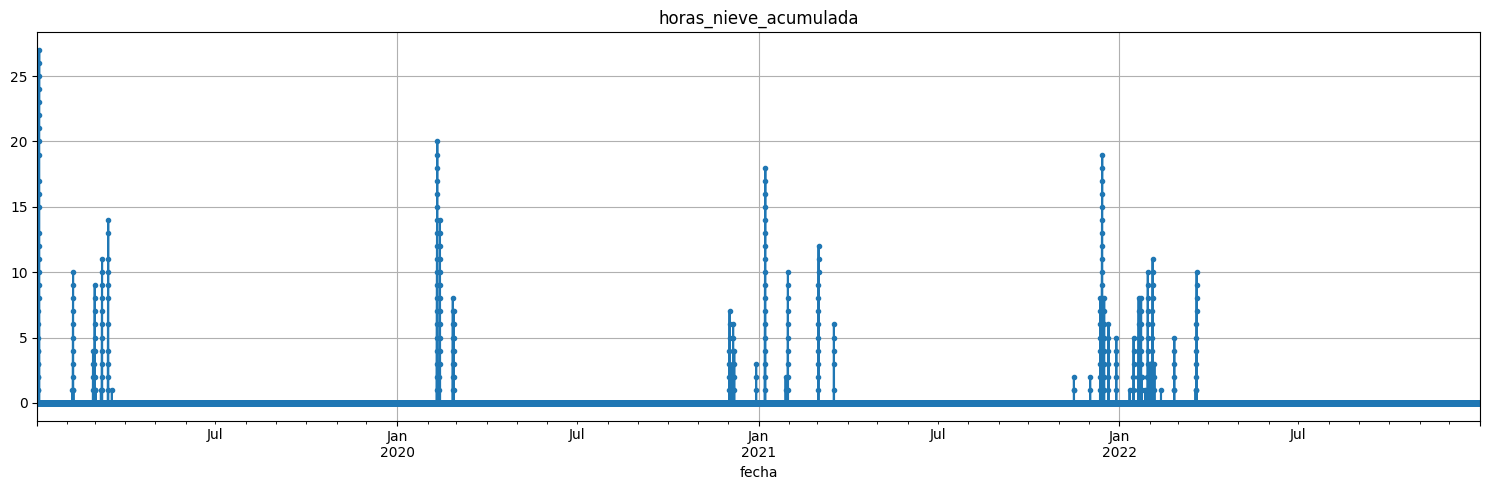

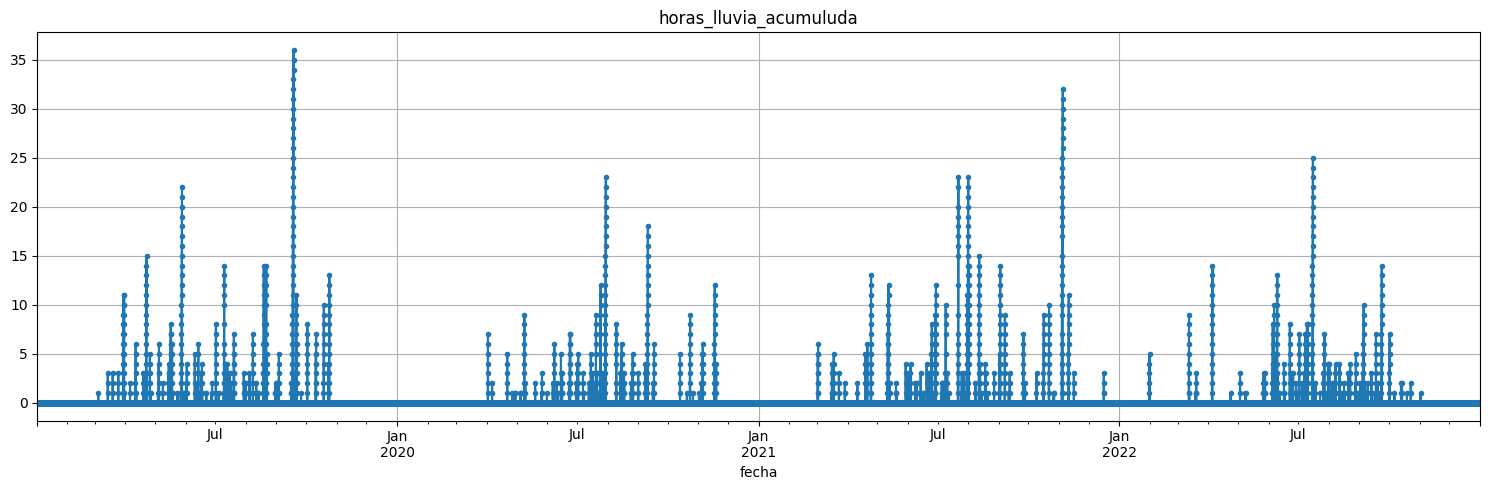

In [26]:
for column in train_set.select_dtypes(include=['float64', 'int64']).columns:
    train_set[column].plot(grid=True, marker=".", figsize=(15, 5), title=column)
    plt.tight_layout()
    plt.show()

### Ejercicio 5

Vamos a preparar el dataset. En principio vamos a predecir el valor de las siguientes 12 horas a partir de las 48 horas anteriores. Es decir hay que ajustar el dataset para que genere batches de 32 secuencias de 48 instancias y con un target que es una secuencia de los 12 periodos siguientes. Primero codifica la dirección del viento con un one-hot encoding sobre el df_indexed. Convierte todos los valores a np.float32 al final: 

In [ ]:





normalization_layer.adapt(train_set[numericas].to_numpy())
_ = [ordinalEncoding_layers[indice].adapt(train_set[col]) for indice,col in enumerate(categoricals)]

earlyS = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights= True)
input_num = tf.keras.layers.Input(shape=(train_set[numericas].shape[1],))
input_cats = [tf.keras.layers.Input(shape=(train_set[[col]].shape[1],), dtype = tf.string) for col in categoricals] # Importante decirle que entra una string
normalized = normalization_layer(input_num)
encoded = [ordinalEncoding_layers[i](input_cats[i]) for i in range(len(ordinalEncoding_layers))]
concat = concat_layer([normalized] + encoded)
hidden1 = hidden_layer1(concat)
output = output_layer(hidden1)

model = tf.keras.Model(inputs=[input_num] + input_cats, outputs=[output])

In [ ]:
seq_length = 48
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_set.to_numpy(),
    targets=train_set[seq_length:],
    sequence_length=seq_length,
    batch_size=32
) 

### Ejercicio 6

Ahora crea los datasets de train, validación y test. El primero para que tenga el periodo 2020 septiembre de 2023, el segundo para octubre de 2023 y el tercero para noviembre de 2023. Ojo ten en cuenta que vamos a necesitar tanto los valores anteriores como posteriores en los periodos (48 horas antes y 12 horas después). Escálalos (importante, escala el target por separado para poder hacer la inversión en el momento de evaluar)

### Ejercicio 8

Crea un modelo con una capa de celdas sencillas recurrentes con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

In [ ]:
x

### Ejercicio 9

Crea un modelo con una capa de celdas LSTM con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.

### Ejercicio 10

Crea un modelo con una capa de celdas GRU con 32 celdas. Entrénalo. Haz la evaluación directa con el método de keras. Utilizar el rmse y el mae como métricas y obténlos en las mismas unidades que el target de partida.